# Implementasi Feed Forward Neural Network

In [45]:
import math
from enum import Enum

E = math.e

## Setup Activation Function


In [46]:
def linearFunction(val: float) -> float:
  return val

def reLUFunction(val: float) -> float :
  return max(0, val)

def sigmoidFunction(val: float) -> float:
  return 1 / (1 + E ** (-val))

def softMaxFunction(val: float) -> float:
  return E ** val

activationFunction = {
  'linear': linearFunction,
  'relu': reLUFunction,
  'sigmoid': sigmoidFunction,
  'softmax' : softMaxFunction
}

## Setup Class

### Class: Node

In [47]:
import string
from typing import List
class Node:
    def __init__(self, id : int, layerId : int, weight: List[float] = None, bias: int = None, activFunctionType : str = None) -> None:
        self.id = id
        self.layerId = layerId
        self.activFunctionType = activFunctionType
        self.weight = weight
        self.bias = bias

    def calculateOutput(self, inputArr: List[float]) -> float:
      sumWeight = 0
      if(len(self.weight) != len(inputArr)):
        raise Exception('Length of weight value array and input array not compatible')
      for i in range(len(self.weight)):
        sumWeight += self.weight[i] * inputArr[i]
      sumWeight += self.bias

      return round(activationFunction[self.activFunctionType](sumWeight), 2)
    
    def describe(self) -> None:
      print(f"Node with id {self.id}:")
      print(f"\tLayer id -> {self.layerId}")
      print(f"\tWeight -> {self.weight}")
      print(f"\tBias -> {self.bias}")
      print(f"\tActivation function -> {self.activFunctionType}")

'''
  Test Case For Node
'''
# instanceNode = Node(1, 1, [1, 0.8, 0.2], 0.3, "Sigmoid")
# instanceNode.describe()
# instanceNode.calculateOutput([1, 2, 3])


'\n  Test Case For Node\n'

### Class: Layer

In [48]:
class LayerType(Enum):
  Input = 1
  Hidden = 2
  Output = 3

class Layer():
  def __init__(self, id: int, nodeAmount: int, layerType : LayerType, nodes : List[Node]) -> None:
    self.id = id
    self.nodeAmount = nodeAmount
    self.layerType = layerType
    self.nodes = nodes # node in here only store non-bias node
    assert self.nodeAmount == len(nodes)
  
  def appendNode(self, newNode : Node) -> None:
    self.nodes.append(newNode)
  
  def describe(self) -> None:
    print(f"Layer with id {self.id}:")
    print(f"\tAmount of node -> {self.nodeAmount}")
    print(f"\tLayer type -> {self.layerType}")
    for node in self.nodes:
      node.describe()

  def __eq__(self, otherLayer) -> bool:
    if isinstance(otherLayer, Layer):
        return self.id == otherLayer.id
    return False
  

### Class: ANNModel

In [49]:
from copy import deepcopy

class ANNModel():
  def __init__(self, layers: List[Layer] = []) -> None:
    self.layers = layers
  
  def appendLayer(self, layer: Layer) -> None:
    self.layers.append(layer)

  def countLayer(self) -> int: 
    return len(self.layers)
  
  def getLayerById(self, layerId: int) -> Layer:
    for layer in self.layers:
      if(layer.id == layerId):
        return layer
    raise Exception("No layer with the prompted id")
  
  def getPreviousLayer(self, targetLayer: Layer) -> Layer:
    if(targetLayer.layerType == LayerType.Input):
      raise Exception("Input layer does not have previous layer")
    prevLayer: Layer = None
    for layer in self.layers:
      if layer == targetLayer:
        return prevLayer
      else: 
        prevLayer = layer
    
    raise Exception("Layer you try to input as parameter is invalid")
  
  def predict(self, inputValue: List[float]) -> List[float]:
    # amountInputNode = 0
    layerCalculation: List[float] = []
    tempArr: List[float] = []
    for layer in self.layers:
      layerCalculation = deepcopy(tempArr)
      tempArr = []
      if layer.layerType == LayerType.Input:
        pass
      else:     
        sum = 0
        for node in layer.nodes:
          if(layer.id == 1):
            tempVal = node.calculateOutput(inputValue)
          else:
            tempVal = node.calculateOutput(layerCalculation)
          sum += tempVal
          tempArr.append(tempVal)
          
        if (layer.nodes[0].activFunctionType == "softmax"):
          # membagi setiap node dengan sum
          for i in range(len(tempArr)):
            tempArr[i] /= sum
    return tempArr
  
  def predictMultiple(self, inputValues: List[List[float]]) -> List[float]:
    result: List[float] = []
    for val in inputValues:
      result.append(self.predict(val))
    return result

  def describe(self) -> None:
    for layer in self.layers:
      layer.describe()
      print("\n")

## File Loader

In [50]:
import json

filename = input("Masukan nama file model: ")
f = open("../model/" + filename)
data = json.load(f)


listInput = data['case']['input']
listWeight = data['case']['weights']
listOutput = data['expect']['output']

descLayers = data['case']['model']['layers']
totalLayer = len(descLayers)

id=0
listLayer = []
for i in range(totalLayer):
    listNode = []
    listCurrentWeights = [[0 for _ in range(len(listWeight[i]))] for _ in range(len(listWeight[i][0]))]
    for j in range(len(listCurrentWeights)):
        for k in range(len(listCurrentWeights[0])):
            listCurrentWeights[j][k]=listWeight[i][k][j]
    for j in range(len(listCurrentWeights)):
        id+=1
        listNode.append(Node(id,i,listCurrentWeights[j][1:],listCurrentWeights[j][0],descLayers[i]['activation_function']))
    if(i!=totalLayer-1):
        listLayer.append(Layer(i+1,len(listNode),LayerType.Hidden,listNode))
    else:
        listLayer.append(Layer(i+1,len(listNode),LayerType.Output,listNode))
annModel = ANNModel(listLayer)

## Hasil Output Layer

In [51]:
annModel.predictMultiple(listInput)

[[2.0, 0.3, -1.9]]

## Visualize ANN

### Dalam bentuk graf

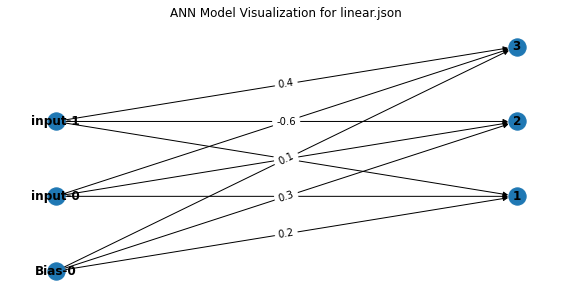

In [52]:
# pip install networkx
import networkx as nx
import matplotlib.pyplot as plt

def drawANNVisualization(annModelInstance: ANNModel):
  G = nx.DiGraph()

  for i, layer in enumerate(annModelInstance.layers):
    currentWeight = listWeight[layer.id - 1][1:]
    # Handle node: general
    for j, node in enumerate(layer.nodes):
      G.add_node(node.id, pos=(i, j))
      if layer.id != 1: # not first hidden layer (second hidden layer to output)
        prevLayer = annModelInstance.getPreviousLayer(layer)
        for k, prevNode in enumerate(prevLayer.nodes):
          G.add_edge(prevNode.id, node.id, weight = currentWeight[j][k])
  
  for inputIdx in range(data['case']['model']['input_size']):
    # * Handle node: input
    G.add_node(f'input-{inputIdx}', pos=(-1, inputIdx))
    # * Handle edge: input to first hidden layer
    for layer in annModelInstance.layers:
      if layer.id == 1: # first hidden layer
        currentWeight = listWeight[layer.id - 1][1:]
        for l, node in enumerate(layer.nodes):
          G.add_edge(f'input-{inputIdx}', node.id, weight = currentWeight[inputIdx][l])
      else:
        break
  
  # * Handle node: bias
  for idx in range(annModelInstance.countLayer()):
    G.add_node(f'Bias-{idx}', pos=(idx - 1, -1))
    for m, layer in enumerate(annModelInstance.layers):
      currentBias = listWeight[idx][0]
      if(layer.id == idx + 1):
        for n, node in enumerate(layer.nodes):
          G.add_edge(f'Bias-{idx}', node.id, weight = currentBias[n])
      

  pos=nx.get_node_attributes(G,'pos')
  edgeLabel = nx.get_edge_attributes(G, 'weight')
  plt.figure(figsize=(10,5))
  ax = plt.gca()
  ax.set_title(f'ANN Model Visualization for {filename}')
  nx.draw(G,with_labels=True,pos=pos, font_weight='bold', ax=ax)
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edgeLabel)

drawANNVisualization(annModel)

### Dalam bentuk teks

In [53]:
annModel.describe()

Layer with id 1:
	Amount of node -> 3
	Layer type -> LayerType.Output
Node with id 1:
	Layer id -> 0
	Weight -> [0.5, 0.3]
	Bias -> 0.2
	Activation function -> linear
Node with id 2:
	Layer id -> 0
	Weight -> [0.2, -0.6]
	Bias -> 0.3
	Activation function -> linear
Node with id 3:
	Layer id -> 0
	Weight -> [-0.8, 0.4]
	Bias -> 0.1
	Activation function -> linear


